<a href="https://colab.research.google.com/github/devt287/applied_stat/blob/main/HW5_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

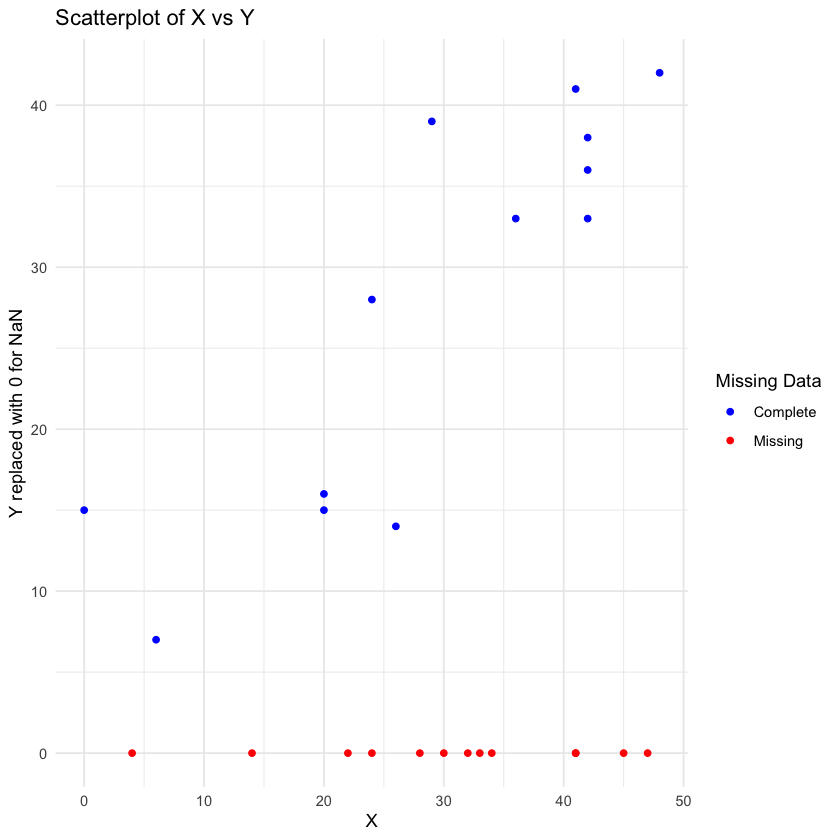

In [41]:

library("ggplot2")

# the dataset (X,Y), which is assumed to be jointly Gaussian
# NaN indicates that the value is missing
X = c(48,36,20,29,42,42,20,42,22,41,45,14,6,
      0,33,28,34,4,32,24,47,41,24,26,30,41)
Y = c(42,33,16,39,38,36,15,33,NaN,NaN,NaN,NaN,7,
      15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,28,14,NaN,NaN)

# YOUR CODE (~3 lines): construct a data frame "df" with three columns:
# "X": the vector X
# "Y": the vector Y with NaN replaced by zero
# "Z": a boolean vector with Z_i = TRUE if Y_i is missing, and = FALSE otherwise

# Creating the dataframe df
df <- data.frame(
  X = X,
  Y = ifelse(is.nan(Y), 0, Y),
  Z = is.nan(Y)
)

# Visualizing the data using ggplot2
ggplot(df, aes(x = X, y = Y, color = Z)) + 
  geom_point() +
  scale_color_manual(values = c("blue", "red"), 
                     name = "Missing Data", 
                     breaks = c(FALSE, TRUE), 
                     labels = c("Complete", "Missing")) +
  labs(title = "Scatterplot of X vs Y", 
       x = "X", 
       y = "Y replaced with 0 for NaN") +
  theme_minimal()

# YOUR CODE (~1 line): use ggplot, draw a scatterplot of (X, Y)
# use different colors for complete & missing data


In [37]:
# the package "mvtnorm" might be useful to calculate multivariate Gaussian densities
# the documentation could be found at https://cran.r-project.org/web/packages/mvtnorm/mvtnorm.pdf

install.packages("mvtnorm")
library("mvtnorm")


The downloaded binary packages are in
	/var/folders/rr/8v9k_gfs7x92pw275qlk3pwc0000gq/T//RtmpdiuqZO/downloaded_packages


In [42]:
log_likelihood <- function(df, mu, sigma){
  # YOUR CODE (~3 lines): given the parameters (mu, sigma) for the bivariate
  # Gaussian distribution, output the incomplete (unnormalized) log-likelihood
  # of the dataset df
  # Input:
  # - df: a data frame consisting of (X, Y, Z)
  # - mu: a 2 * 1 mean vector of the Gaussian distribution
  # - sigma: a 2 * 2 covariance matrix of the Gaussian distribution
  # Output: a scalar value, which is the overall log-likelihood
  # Note: the dmvnorm() and dnorm() functions might be helpful to compute log
  # densities for the multivariate & univariate Gaussian distributions
    # Calculate log-likelihood for complete cases (Z = FALSE)
  log_lik_complete <- sum(dmvnorm(x = df[df$Z == FALSE, 1:2], mean = mu, sigma = sigma, log = TRUE))
  
  # Calculate log-likelihood for cases with missing Y (Z = TRUE)
  # We need to extract the marginal distribution of X from the bivariate Gaussian distribution.
  mu_X <- mu[1]
  sigma_X <- sigma[1, 1]
  log_lik_missing <- sum(dnorm(x = df[df$Z == TRUE, "X"], mean = mu_X, sd = sqrt(sigma_X), log = TRUE))
  
  # Return the overall log-likelihood
  return(log_lik_complete + log_lik_missing)

}






In [43]:
# This is the function for the EM recursion
# Input: the dataset df, and the current parameters (mu, sigma)
# Output: the updated parameters (mu_new, sigma_new)
EM_recursion <- function(df, mu, sigma){
  # YOUR CODE (~2 lines): compute a conditional mean vector cond_mean
  # if Y_i is not missing, then cond_mean_i = X_i;
  # if Y_i is missing, then cond_mean_i is the conditional mean of Y_i given X_i
  # under the current parameters (mu, sigma) in the Gaussian distribution
  # This quantity is essentially the E-step for the mean

  sigma_X_inv = 1 / sigma[1, 1]
  sigma_XY = sigma[1, 2]
  cond_mean = ifelse(df$Z, 
                    mu[2] + sigma_XY * sigma_X_inv * (df$X - mu[1]), 
                    df$Y)

  # update of mu; this is the M-step for the mean
  mu_new = c(mean(df$X), mean(cond_mean))

  # YOUR CODE (~2 lines): compute a conditional variance vector cond_var
  # if Y_i is not missing, then cond_var_i = 0;
  # if Y_i is missing, then cond_var_i is the conditional variance of Y_i given
  # X_i under the current parameters (mu, sigma) in the Gaussian distribution
  # This quantity is essentially the E-step for the covariance

  sigma_Y = sigma[2, 2]
  sigma_YX = sigma[2, 1]
  cond_var = ifelse(df$Z, 
                    sigma_Y - sigma_XY * sigma_X_inv * sigma_YX, 
                    0)

  # update of sigma: this is the M-step for the covariance
  sigma_new = matrix(c(0,0,0,0), nrow = 2, ncol = 2)
  sigma_new[1,1] = mean((df$X - mu_new[1])^2)
  sigma_new[1,2] = mean((df$X - mu_new[1]) * (cond_mean - mu_new[2]))
  sigma_new[2,1] = sigma_new[1,2]
  sigma_new[2,2] = mean((cond_mean - mu_new[2])^2 + cond_var)

  return(list(mu = mu_new, sigma = sigma_new))
}

In [44]:
# The overall EM algorithm
# You do not need to change any code in this cell; you only need to run it

# Initialization
mu = c(0,0)
sigma = matrix(c(100,0,0,100), nrow = 2, ncol = 2)
ll = log_likelihood(df,mu,sigma)
tol = 1e-4 # tolerance used in the stopping criterion
print(ll) # print the log likelihood for your reference

while(TRUE){
  # update (mu, sigma)
  theta = EM_recursion(df, mu, sigma)
  ll_new = log_likelihood(df, theta$mu, theta$sigma)
  print(ll_new) # print the new log likelihood for your reference

  if (ll_new - ll < tol) {break} # stopping criterion

  mu = theta$mu
  sigma = theta$sigma
  ll = ll_new
}

# You should see that the EM iteration converges after ~15 iterations
# You should also see that the log-likelihood keeps increasing
# If you don't observe so, go back and check your code

# print the final solution (mu, sigma); include the output in your report
print(mu)
print(sigma)

[1] -320.3494
[1] -158.3237
[1] -153.4698
[1] -150.2142
[1] -147.9178
[1] -146.536
[1] -145.868
[1] -145.6081
[1] -145.5231
[1] -145.4984
[1] -145.4917
[1] -145.4899
[1] -145.4895
[1] -145.4894
[1] -145.4893
[1] 29.65385 27.98097
        [,1]     [,2]
[1,] 171.534 122.9060
[2,] 122.906 124.0466


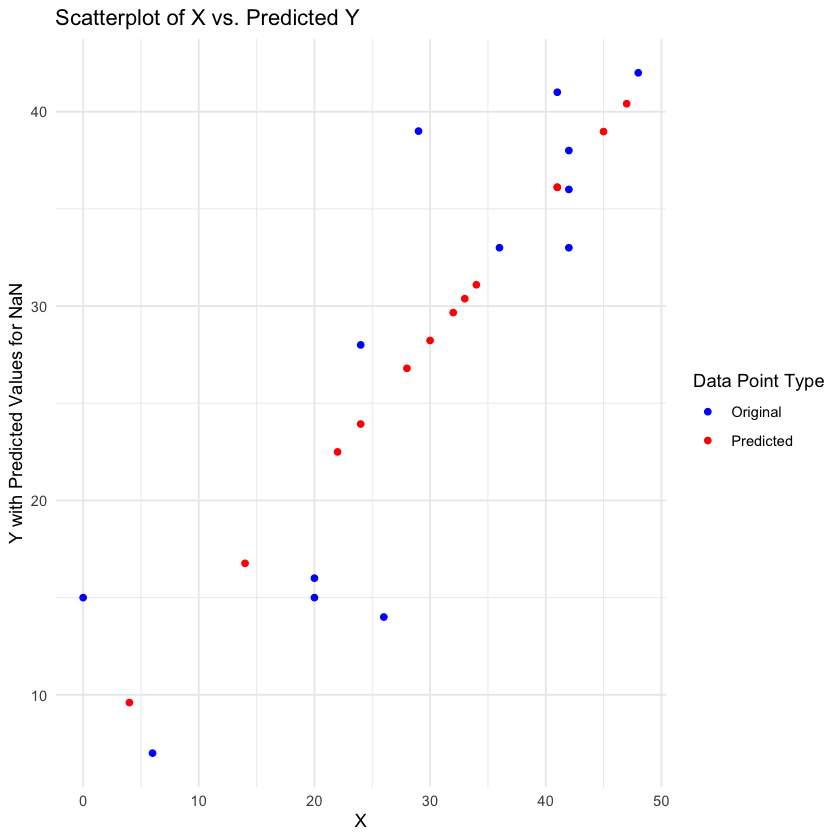

In [45]:
# YOUR CODE (~3 lines):
# 1. based on the final (mu, sigma), compute the predicted values for the missing
# sigma=A matrix: 2 × 2 of type dbl 171.534	122.9060 //122.906	124.0466

#    values of Y; these should just be the conditional mean of Y given X
# 2. use ggplot, draw a scatterplot of (X, Y) with missing values replaced by
#    the above predictions; use different colors according to Z


sigma_X_inv = 1 / sigma[1, 1]
sigma_XY = sigma[1, 2]
df$predicted_Y = ifelse(df$Z, 
                        mu[2] + sigma_XY * sigma_X_inv * (df$X - mu[1]), 
                        df$Y)

# Scatterplot using ggplot2
ggplot(df, aes(x = X, y = predicted_Y, color = Z)) + 
  geom_point() +
  scale_color_manual(values = c("blue", "red"), 
                     name = "Data Point Type", 
                     breaks = c(FALSE, TRUE), 
                     labels = c("Original", "Predicted")) +
  labs(title = "Scatterplot of X vs. Predicted Y", 
       x = "X", 
       y = "Y with Predicted Values for NaN") +
  theme_minimal()





